In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#Images must be PNG!
data_path = 'C:/Users/claudia/masks'
train_images_path = os.path.join(data_path, 'images')
train_annotations_path = os.path.join(data_path, 'annotations')
test_images_path = os.path.join(data_path, 'test')

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [4]:
imgs = list(sorted(os.listdir(train_images_path)))

In [5]:
labels = list(sorted(os.listdir(train_annotations_path)))

In [6]:
class MaskDataset(object):
    def __init__(self, transforms, is_test=False):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(test_images_path if is_test else train_images_path)))
        self.is_test = is_test
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(test_images_path if self.is_test else train_images_path, file_image)
        label_path = os.path.join(train_annotations_path, file_label)
        img = Image.open(img_path).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
        
        # to test, we don't need any target     
        if self.is_test:
            return img, None
        #Generate Label
        target = generate_target(idx, label_path)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [9]:
torch.cuda.is_available()

False

# Model

In [10]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [11]:
model = get_model_instance_segmentation(3)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]]), 'labels': tensor([0, 1, 0]), 'image_id': tensor([0])}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0]), 'image_id': tensor([1])}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]]), 'labels': tensor([1, 1, 1, 2]), 'image_id': tensor([2])}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
        [112.,  51., 120.,  68.],
        [155.,  60., 177.,  83.],
        [189.,  59., 210.,  80.],
        [235.,  57., 257.,  78.],
        [289.,  60.

# Train Model

In [13]:
# num_epochs = 25
# #num_epochs = 1
# model.to(device)
    
# # parameters
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005,
#                                 momentum=0.9, weight_decay=0.0005)

# len_dataloader = len(data_loader)

# for epoch in range(num_epochs):
#     print(epoch)
#     model.train()
#     i = 0    
#     epoch_loss = 0
#     for imgs, annotations in data_loader:
#         i += 1
#         imgs = list(img.to(device) for img in imgs)
#         annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
#         loss_dict = model([imgs[0]], [annotations[0]])
#         losses = sum(loss for loss in loss_dict.values())        

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step() 
#         #print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
#         epoch_loss += losses
#     print(epoch_loss)


In [14]:
# for imgs, annotations in data_loader:
#         imgs = list(img.to(device) for img in imgs)
#         annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
#         break

In [15]:
# model.eval()
# preds = model(imgs)
# preds

# Function to plot image

In [16]:
# import matplotlib.patches as patches
# import matplotlib.pyplot as plt
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [17]:
# torch.save(model.state_dict(),'model.pt')

In [18]:
#print("Prediction")
#plot_image(imgs[2], preds[2])
#print("Target")
#plot_image(imgs[2], annotations[2])

In [19]:
model2 = get_model_instance_segmentation(3)

# Save Model

In [20]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [21]:
pred2 = model2(imgs)

In [22]:
# import matplotlib.patches as patches
# import matplotlib.pyplot as plt
# print("Predict with loaded model")
# img_tensor, annotation = imgs[0], pred2[0]
# fig,ax = plt.subplots(1)
# img = img_tensor.cpu().data

# Display the image
# ax.imshow(img.permute(1, 2, 0))

# for box in annotation["boxes"]:
#     xmin, ymin, xmax, ymax = box

#     # Create a Rectangle patch
#     rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

#     # Add the patch to the Axes
#     ax.add_patch(rect)

# plt.show()
# plot_image(imgs[0], pred2[0])

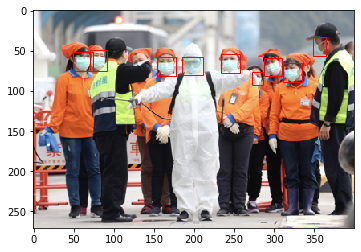

In [23]:
plot_image(imgs[-1], pred2[-1])

# Test the model

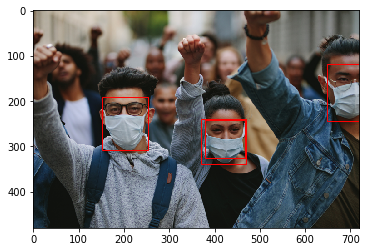

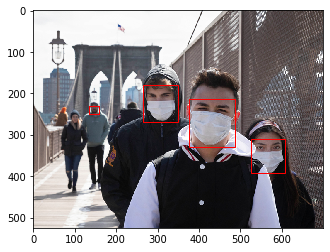

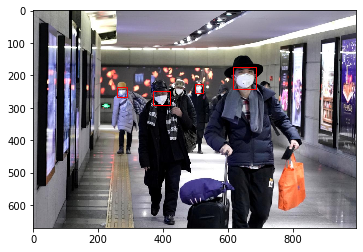

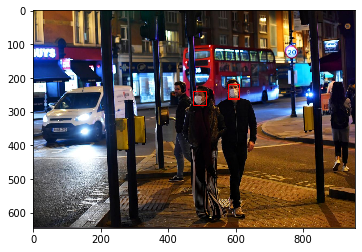

In [24]:
len_test = 4
dataset = MaskDataset(data_transform, True)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=len_test, collate_fn=collate_fn)
for imgs, annotations in data_loader:
    break
pred2 = model2(imgs)
for i in range(len_test):
    plot_image(imgs[i], pred2[i])